In [1]:
import numpy as np
from numpy import save
from numpy import asarray
from numpy import load

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
import progressbar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU


In [2]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
# Loading mat file and returning file
def loadMatFile(fileName, key):
    mat = loadmat(fileName)[key]
    print("Loaded:",fileName, key)
    return mat

In [4]:
# Plot 3D points given file and frame number
def plotKnownOrder(matFile, numb):
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    # addLabels(ax, x, y, z)
    drawLines(ax, x, y, z)
    drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            x_line = [x[idx[0]-1], x[idx[1]-1]]
            y_line = [y[idx[0]-1], y[idx[1]-1]]
            z_line = [z[idx[0]-1], z[idx[1]-1]]
            z_coord_1 = x[idx[0]-1], y[idx[0]-1], z[idx[0]-1]
            z_coord_2 = x[idx[1]-1], y[idx[1]-1], z[idx[1]-1]

            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

In [5]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)
    # return matrix

In [6]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    return normalize(dist)

In [7]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    reshaped = int(matFile.shape[2])
    height = []

    for i in range(reshaped):
        for j in range(reshaped):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(reshaped, reshaped))
    return height


In [8]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle)

In [9]:
def addNans(raw):
    raw_copy = np.array(raw.copy())

    for i in range(raw_copy.shape[0]):
        rand_numb = np.random.randint(0, 4)
        rand_index = random.sample(range(3, 20), rand_numb)
        for j in range(rand_numb):
            raw_copy[i][:,rand_index[j]] = np.nan
    return raw_copy


In [10]:
def getData(data, numb): 
    cnn_inputs = []
    bar = progressbar.ProgressBar()

    for i in bar(range(numb)):
        dist = getAllDistances(data, i) 
        height = getAllHeights(data, i)
        angle = getAllAngles(data, i)
        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            # first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

    # DIMENTION CHANGE
    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    # cnn_inputs = np.array(cnn_inputs)[:,:,:20]
    cnn_inputs = np.array(cnn_inputs).reshape((cnn_inputs.shape[0], 39))
    # cnn_inputs = np.array(cnn_inputs).reshape((numb*data.shape[2], 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [11]:
def oneFileTestTrain():
    mat_file = loadmat('mat_files/markerSplit_1_shuffled.mat')
    data = mat_file['alteredM']
    labels = mat_file['labelsM']

    # set numb of data used
    numb_train = 2000
    numb_test = 2000

    # find length of data
    mat_len = int(len(labels))
    mat_half = int(mat_len/2)

    # Take some frames from the list to use as trian and test data
    index_train = np.linspace(0, mat_half, num = numb_train, endpoint=False).astype(int)
    index_test = np.linspace(mat_half, mat_len, num = numb_test, endpoint=False).astype(int)
    pre_train_data = data[index_train]
    pre_train_labels = labels[index_train]
    pre_test_data = data[index_test]
    pre_test_labels = labels[index_test]

    print("Shape of pre_train_data:", pre_train_data.shape)
    print("Shape of pre_test_data:", pre_test_data.shape)
    print("Shape of pre_train_labels:", pre_train_labels.shape)
    print("Shape of pre_test_labels:", pre_test_labels.shape)
    return pre_train_data, pre_test_data, pre_train_labels, pre_test_labels

In [12]:
train_file = loadmat('mat_files/bigSet1.mat')
test_file = loadmat('mat_files/bigSet2.mat')

In [13]:
train_data = train_file['bigSet1']
test_data = test_file['bigSet2']
train_labels = train_file['labels1']
test_labels = test_file['labels2']
# set numb of data used
numb_train = len(train_data)
numb_test = 1000

# Take some frames from the list to use as trian and test data
index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
# pre_train_data = train_data[index_train]
# pre_train_labels = train_labels[index_train]
pre_train_data = train_data
pre_train_labels = train_labels
pre_test_data = test_data[index_test]
pre_test_labels = test_labels[index_test]

print("Shape of pre_train_data:", pre_train_data.shape)
print("Shape of pre_test_data:", pre_test_data.shape)
print("Shape of pre_train_labels:", pre_train_labels.shape)
print("Shape of pre_test_labels:", pre_test_labels.shape)


Shape of pre_train_data: (221147, 3, 20)
Shape of pre_test_data: (1000, 3, 20)
Shape of pre_train_labels: (221147, 20)
Shape of pre_test_labels: (1000, 20)


In [14]:
# Get measurement data for every 3D point
train_data = getData(pre_train_data, numb_train)
test_data = getData(pre_test_data, numb_test)

# Flatten the trian labels to fit dimentions of data
train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

100% (221147 of 221147) |################| Elapsed Time: 0:07:56 Time:  0:07:56
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Shape of train_data: (4422940, 39)
Shape of test_data: (20000, 39)
Shape of train_labels: (4422940,)
Shape of test_labels: (20000,)


In [15]:
# Get index where the data is all 0
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

# Turn data into lists
train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

bar = progressbar.ProgressBar()
# Remove the nan values 
for i in bar(nans_train):
    train_data_new.pop(i)
    train_labels_new.pop(i)
bar = progressbar.ProgressBar()
for i in bar(nans_test):
    test_data_new.pop(i)
    test_labels_new.pop(i)

# Turn data back into array
train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print("Shape of train_data_new:", train_data_new.shape)
print("Shape of test_data_new:", test_data_new.shape)
print("Shape of train_labels_new:", train_labels_new.shape)
print("Shape of test_labels_new:", test_labels_new.shape)

100% (397563 of 397563) |################| Elapsed Time: 0:32:30 Time:  0:32:30
100% (1741 of 1741) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


Shape of train_data_new: (4025377, 39)
Shape of test_data_new: (18259, 39)
Shape of train_labels_new: (4025377,)
Shape of test_labels_new: (18259,)


In [16]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    train_data = train_data.reshape(train_data.shape[0], 39)
    test_data = test_data.reshape(test_data.shape[0], 39)
    # train_data = train_data.reshape(train_data.shape[0], 60)
    # test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=20, epochs=2)
    
    output = model.evaluate(test_data, test_labels)
    print("Loss:", output[0])
    print("Accuracy:", output[1]*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(120, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    model.add(Dense(80, activation= LeakyReLU()))
    # model.add(Dense(13, activation = "softmax"))
    model.add(Dense(len(joint_name), activation = "softmax"))
    return model

In [17]:
# save_train_data = asarray(train_data_new)
# save_train_labels = asarray(train_labels_new)
# save_test_data = asarray(test_data_new)
# save_test_labels = asarray(test_labels_new)

In [18]:
# folder = 'datasets/'
# save(folder + 'train_data.npy', save_train_data)
# save(folder + 'train_labels.npy', save_train_labels)
# save(folder + 'test_data.npy', save_test_data)
# save(folder + 'test_labels.npy', save_test_labels)

In [19]:
skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

Epoch 1/2
201269/201269 [==============================] - 473s 2ms/step - loss: 0.4460 - accuracy: 0.8522
Epoch 2/2
571/571 [==============================] - 1s 2ms/step - loss: 0.5593 - accuracy: 0.8516
Loss: 0.5593456625938416
Accuracy: 85.16348004341125


In [20]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    img = np.array(img).reshape(3,13)
    # img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    pred = model.predict(img.reshape(1, 39))
    # pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

    

In [21]:
# temp = test_data[0].reshape(3,13)
# print(temp)
# plt.imshow(temp)

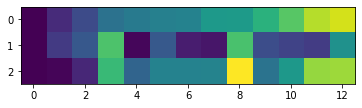

Actual: 0
Predicted: 0
YAY ✿(ᵔ‿ᵔ)


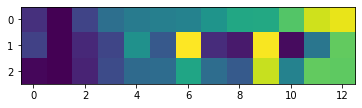

Actual: 1
Predicted: 1
YAY ✿(ᵔ‿ᵔ)


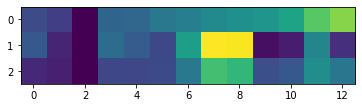

Actual: 2
Predicted: 2
YAY ✿(ᵔ‿ᵔ)


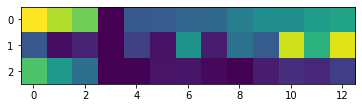

Actual: 7
Predicted: 7
YAY ✿(ᵔ‿ᵔ)


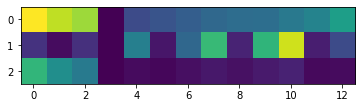

Actual: 5
Predicted: 5
YAY ✿(ᵔ‿ᵔ)


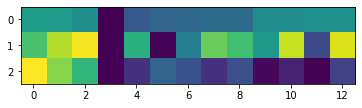

Actual: 10
Predicted: 11
Wrong (◕︵◕)


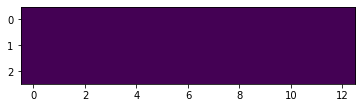

Actual: 11
Predicted: 10
Wrong (◕︵◕)


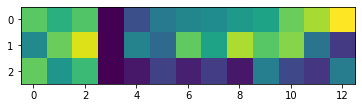

Actual: 13
Predicted: 13
YAY ✿(ᵔ‿ᵔ)


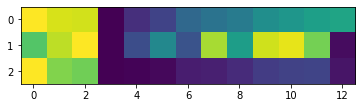

Actual: 19
Predicted: 19
YAY ✿(ᵔ‿ᵔ)


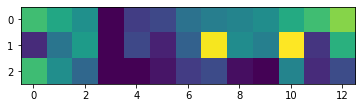

Actual: 12
Predicted: 12
YAY ✿(ᵔ‿ᵔ)


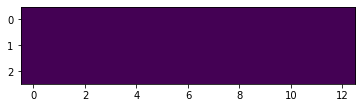

Actual: 14
Predicted: 10
Wrong (◕︵◕)


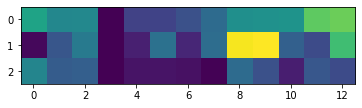

Actual: 3
Predicted: 3
YAY ✿(ᵔ‿ᵔ)


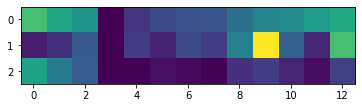

Actual: 6
Predicted: 6
YAY ✿(ᵔ‿ᵔ)


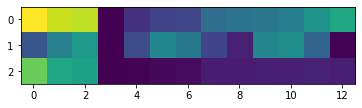

Actual: 9
Predicted: 9
YAY ✿(ᵔ‿ᵔ)


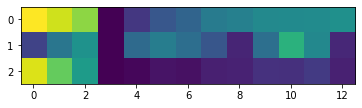

Actual: 17
Predicted: 17
YAY ✿(ᵔ‿ᵔ)


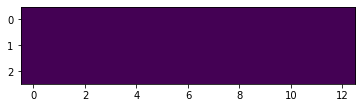

Actual: 8
Predicted: 10
Wrong (◕︵◕)


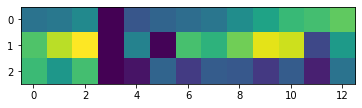

Actual: 15
Predicted: 15
YAY ✿(ᵔ‿ᵔ)


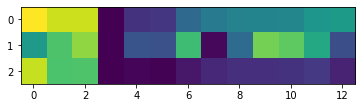

Actual: 16
Predicted: 16
YAY ✿(ᵔ‿ᵔ)


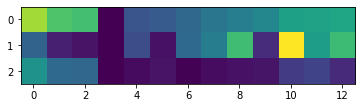

Actual: 4
Predicted: 4
YAY ✿(ᵔ‿ᵔ)


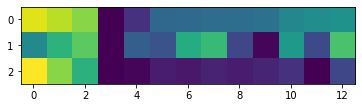

Actual: 18
Predicted: 18
YAY ✿(ᵔ‿ᵔ)


In [22]:
for i in range(420,440):
    handTest(i, test_data, test_labels, skeleton_model, numb_test)

Train input


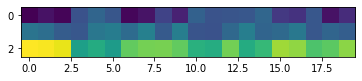

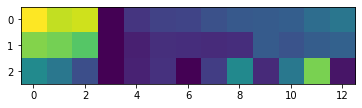

Test input


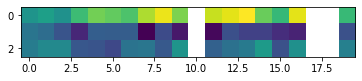

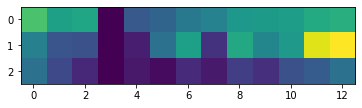

In [23]:
index = 1234
frame = int(index/20)

print("Train input")
plt.imshow(pre_train_data[frame].reshape(3,20))
plt.show()
# DIMENTION CHANGE
plt.imshow(train_data[index].reshape(3,13))
# plt.imshow(train_data[index].reshape(3,20))
plt.show()

print("Test input")
plt.imshow(pre_test_data[frame].reshape(3,20))
plt.show()
plt.imshow(test_data[index].reshape(3,13))
# plt.imshow(test_data[index].reshape(3,20))
plt.show()

In [24]:
temporal = loadmat('mat_files/test_temp.mat')

In [54]:
time_pts = temporal['new_combed']
num_fms = 3000
num_pts = int(time_pts.shape[0]/3) #22
test_pts = time_pts[:,:num_fms]

plt.imshow(time_pts, interpolation='nearest', aspect="auto")
plt.show()
# plt.imshow(test_pts, interpolation='nearest', aspect="auto")
# plt.show()

In [26]:
input_pts = test_pts.reshape(num_pts, 3, num_fms).T

In [27]:
processed_time = getData(input_pts, len(input_pts))
process_pts = processed_time.reshape(3000, 22, 39)

100% (3000 of 3000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


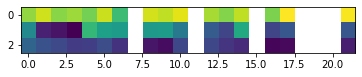

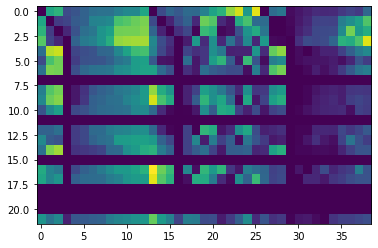

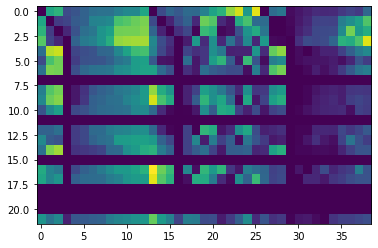

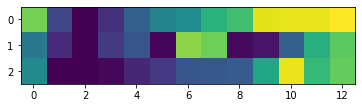

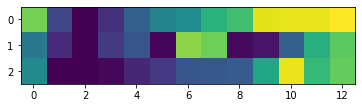

In [28]:
# Check if process_pts is valid

frame_index = 2999
pt = 2
plt.imshow(input_pts[frame_index].reshape(3,num_pts))
plt.show()

plt.imshow(process_pts[frame_index], interpolation='nearest', aspect="auto")
plt.show()


temp = processed_time.reshape(3000, 22, 39)
processed = np.transpose(temp,(1, 0, 2))

# plt.imshow([presplit_process[frame_index]], interpolation='nearest', aspect="auto")
plt.imshow(processed[:,frame_index], interpolation='nearest', aspect="auto")
plt.show()

plt.imshow(process_pts[frame_index][pt].reshape(3,13))
plt.show()
plt.imshow(processed[pt][frame_index].reshape(3,13))
plt.show()

In [48]:
chunks = []
temp = np.ones((22,3000))
bar = progressbar.ProgressBar()
# run through all the registered points (0,22)
for i in bar(range(num_pts)):
    # get every third row
    row = i*3
    row_list = []
    temp_list = []

    # run through length of each row (0,3000)
    for j in range(num_fms): 
        # not a nan, add index to list
        if not np.isnan(test_pts[row][j]):
            temp_list.append(j)
            temp[i][j] = temp[i][j]*2
        # if element is a nan and the current list is not empty
        elif len(temp_list) > 0:
            # add list to output and clear the list
            row_list.append([temp_list[0], temp_list[-1]])
            temp_list = []
    # edge case, add to output if the list still contains values
    if len(temp_list) > 0:
        row_list.append([temp_list[0], temp_list[-1]])
    chunks.append(row_list)

100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [52]:
# plt.imshow(temp, interpolation='nearest', aspect="auto")
# plt.show
plt.imshow(test_pts, interpolation='nearest', aspect="auto")

In [31]:
# Check the chunk list
chunks = np.array(chunks, dtype=list)
for i in range(len(chunks)):
    print("Point: "+str(i) +", Chunks: " + str(len(chunks[i])))

Point: 0, Chunks: 1
Point: 1, Chunks: 1
Point: 2, Chunks: 1
Point: 3, Chunks: 1
Point: 4, Chunks: 1
Point: 5, Chunks: 1
Point: 6, Chunks: 1
Point: 7, Chunks: 11
Point: 8, Chunks: 1
Point: 9, Chunks: 1
Point: 10, Chunks: 1
Point: 11, Chunks: 12
Point: 12, Chunks: 1
Point: 13, Chunks: 7
Point: 14, Chunks: 1
Point: 15, Chunks: 27
Point: 16, Chunks: 9
Point: 17, Chunks: 34
Point: 18, Chunks: 26
Point: 19, Chunks: 18
Point: 20, Chunks: 12
Point: 21, Chunks: 24


In [35]:
from scipy import stats
temporal_data = []
# segment_range = []
confidence_levels = []

# loop through all the points (0,22)
for i in range(len(chunks)):
# for i in range(3):
    seg_range = []
    mode_predict = []
    conf_predict = []
    conf_level = []

    # list of chunks in a row
    data = chunks[i]
    print("\nPoint: "+ str(i) + ", Segments: " + str(len(data)))
    # loop through all the chunks per row (0,1)
    for j in range(len(data)):
        conf = []
        pred = []
        seg = data[j] #segment range ie. [0,2999]
        lower = seg[0]
        upper = seg[1]+1
        seg_len = upper - lower
        
        # loop through range of each chunk (0,3000)
        bar = progressbar.ProgressBar()
        for k in range(lower, upper): 
            # if k < 5:
            #     plt.imshow(processed[i][k].reshape(3,13))
            #     plt.show()
            model_pred = skeleton_model.predict(processed[i][k].reshape(1,39))

            # get the confidence of predicition
            if len(conf) == 0: 
                conf = model_pred[0]
            else:
                conf += model_pred[0]

            # get prediction
            pred.append(model_pred.argmax())
            
        # turn into arrays
        conf = np.array(conf)
        pred = np.array(pred)

        # get mode predictions
        mode_data = stats.mode(pred, axis = 0)
        mode_pred = mode_data[0].flatten()[0]
        mode_count = mode_data[1].flatten()[0]
        mode_conf = mode_count/seg_len

        # get confidence predictions
        conf_pred = conf.argmax()
        conf_count = np.sum(pred == conf_pred)
        conf_conf = conf.max()/seg_len

        # adding to output arrays
        # seg_range.append(seg)
        conf_level.append(conf)
        mode_predict.append([mode_pred, mode_conf, seg, (seg_len-mode_count), mode_count, seg_len])
        conf_predict.append([conf_pred, conf_conf, seg, (seg_len-conf_count), conf_count, seg_len])

        # Display current state
        print("Segment: "+str(j) + ")", seg, "Predicted point: (M:" + str(mode_pred) + ", C:" + str(conf_pred) + "), [" + str(mode_count) + ", " + str(conf_count) + "] /", seg_len, end = " ")
        if (mode_pred == conf_pred):
            print("Yay")
        else:
            print("Conflict")
    
    # adding to output arrays
    confidence_levels.append(conf_level)
    # segment_range.append(sorted(seg_range))
    temporal_data.append([mode_predict, conf_predict])


Point: 0, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:0, C:0), [3000, 3000] / 3000 Yay

Point: 1, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:1, C:1), [2994, 2994] / 3000 Yay

Point: 2, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:2, C:2), [2868, 2868] / 3000 Yay

Point: 3, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:14, C:14), [2250, 2250] / 3000 Yay

Point: 4, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:8, C:8), [2912, 2912] / 3000 Yay

Point: 5, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:5, C:5), [1957, 1957] / 3000 Yay

Point: 6, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:5, C:5), [2444, 2444] / 3000 Yay

Point: 7, Segments: 11
Segment: 0) [0, 190] Predicted point: (M:18, C:18), [185, 185] / 191 Yay
Segment: 1) [192, 214] Predicted point: (M:18, C:18), [23, 23] / 23 Yay
Segment: 2) [216, 344] Predicted point: (M:18, C:18), [115, 115] / 129 Yay
Segment: 3) [346, 1432] Predicted point: (M:8, C:8), [602, 602] / 10

In [ ]:
temporal_data

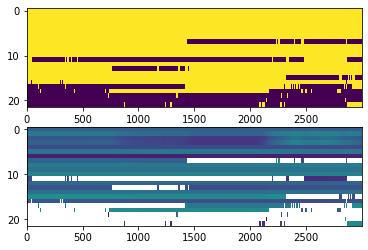

In [36]:
temp_new = np.ones((22,3000))
for i in range(len(temporal_data)):
    for j in range(len(temporal_data[i])):
        for k in range(len(temporal_data[i][j])):
            start = temporal_data[i][j][k][2][0]
            end = temporal_data[i][j][k][2][1] + 1
            for k in range(start, end):
                temp_new[i][k] +=1
fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(temp_new, interpolation='nearest', aspect="auto")
ax2.imshow(test_pts[::3], interpolation='nearest', aspect="auto")

In [37]:
temp_copy = temporal_data.copy()
temp_data = np.array(temp_copy, dtype=object)
chunk_data = []
pred_data = temp_data[:,1] # 1 for confidence
# pred_data = temp_data[:,0] # 0 for mode
print(pred_data.shape)

for i in range(20):
    chunk_data.append([])

# putting the preditions into buckets
for i in range(20):
    index = pred_data[i]
    for j in range(len(index)):
        chunk_data[index[j][0]].append([i]+index[j])

for i in range(len(chunk_data)):
    print(i, len(chunk_data[i]))

(22,)
0 1
1 1
2 1
3 2
4 7
5 16
6 2
7 1
8 54
9 1
10 5
11 0
12 8
13 20
14 19
15 2
16 0
17 1
18 15
19 0


In [38]:
processed_pts = []

# squish all the data points
for i in range(20): 
    numb_index = []
    bounds = None
    current = chunk_data[i]
    sorted_current = sorted(current,key=lambda x: x[4])

    for j in reversed(range(len(sorted_current))):
        input_index = sorted_current[j]
        current_bounds = np.arange(input_index[3][0], input_index[3][1]+1).tolist()

        if len(numb_index) == 0:
            numb_index.append(input_index)
            bounds = current_bounds
        else:
            same = list(set(current_bounds) & set(bounds)) # gets overlapping elements 
            # no overlapp between the two lists
            if len(same) == 0:
                numb_index.append(input_index)
                bounds += current_bounds
            else: #if there is overlap between the two lists
                if current_bounds[0] in bounds and current_bounds[-1] in bounds:
                    # print(str(i) + ") Can't add index in range [" + str(current_bounds[0]) + ", " + str(current_bounds[-1]) + "] to [" + str(bounds[0])+ ", " + str(bounds[-1]) + "]")
                    pass
                elif current_bounds[0] in bounds:
                    print("Lower bound inside current bounds")
                    pass
                elif current_bounds[-1] in bounds:
                    print("Upper bound inside current bounds")
                    pass
        bounds = sorted(bounds)
    processed_pts.append(numb_index)       
 

Lower bound inside current bounds
Lower bound inside current bounds
Lower bound inside current bounds
Lower bound inside current bounds


In [40]:
processed_pts = np.array(processed_pts, dtype = object)
for i in range(len(processed_pts)):
    print("Point:", i, end = " --> ")
    for j in range(len(processed_pts[i])):
        print(processed_pts[i][j][0], end = ", ")
    print("")

Point: 0 --> 0, 
Point: 1 --> 1, 
Point: 2 --> 2, 
Point: 3 --> 12, 
Point: 4 --> 11, 11, 11, 19, 19, 19, 
Point: 5 --> 5, 
Point: 6 --> 13, 13, 
Point: 7 --> 10, 
Point: 8 --> 7, 7, 19, 7, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 
Point: 9 --> 18, 
Point: 10 --> 18, 16, 18, 17, 17, 
Point: 11 --> 
Point: 12 --> 16, 16, 16, 16, 16, 16, 16, 16, 
Point: 13 --> 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 7, 7, 
Point: 14 --> 15, 17, 17, 19, 19, 17, 17, 17, 17, 17, 
Point: 15 --> 13, 13, 
Point: 16 --> 
Point: 17 --> 8, 
Point: 18 --> 9, 
Point: 19 --> 


In [41]:
final_points = []
point_coord = np.ones((60,3000))*np.nan

for i in range(len(processed_pts)):
    index = [i*3, i*3+1, i*3+2]
    coord = [[],[],[]]

    for j in range(len(processed_pts[i])):
        seg_range = processed_pts[i][j]
        org_index = seg_range[0]
        start = seg_range[3][0]
        end = seg_range[3][1]
        # print(i,org_index,start,end)
        index_xyz = [org_index*3, org_index*3+1, org_index*3+2]

        for k in range(start, end):
            point_coord[index[0]][k] = test_pts[index_xyz[0]][k]
            point_coord[index[1]][k] = test_pts[index_xyz[1]][k]
            point_coord[index[2]][k] = test_pts[index_xyz[2]][k]
            if np.isnan(test_pts[index_xyz[0]][k]):
                print("big error", org_index, k)

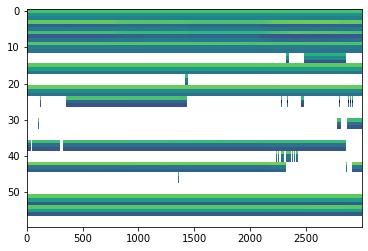

In [42]:
plt.imshow(point_coord, interpolation='nearest', aspect="auto")
plt.show()

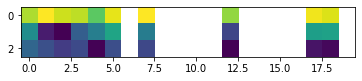

In [43]:
temp = point_coord.copy()
temp_2 = np.transpose(temp.T.reshape(3000, 20, 3), (0,2,1))
plt.imshow(temp_2[2500])
plt.show()

In [ ]:
# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            first_pt = idx[0]-1
            second_pt = idx[1]-1
            x_line = [x[first_pt], x[second_pt]]
            y_line = [y[first_pt], y[second_pt]]
            z_line = [z[first_pt], z[second_pt]]
            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

def addLabels(ax, x, y, z):
    # run through all the points to add labels
    for i in range(len(x)):
        try:
            # points_array.append([x[i], y[i], z[i]])
            # label = np.around(points_array[i]).astype(int)
            label = joint_name[i]
            if not np.isnan(x[i]):
                ax.text(x[i], y[i], z[i], label)
            # print(i, ":", points_array[i], joint_name[i])
        except:
            pass

In [45]:
%matplotlib tk

# Plot 3D points given file and frame number
def plotFrame(frame):
    x = frame[0]
    y = frame[1]
    z = frame[2]

    # plt.imshow([x, y,z])
    # plt.show()

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    drawLines(ax, x, y, z)
    # drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

plotFrame(temp_2[500])